In [1]:
import os
import sys
sys.path.append('/home/hkhachatrian/mae/')
import cv2
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn

from get_model import get_model, get_model_config
from modeling import Encoder
from tracking.utils import get_files
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

In [2]:
MODELS = ['dino', 'dinov2', 'mae']
model_title = {
    'dino': "DINO",
    'dinov2': "DINOv2",
    'ibot':"iBOT",
    'sup_vit': "Supervised ViT",
    'mae': "MAE",
    'mae200': "MAE_200",
    'simmim': 'SimMIM'
}

In [3]:
video_embeds = {}
img_size = (224 * 3, 224 * 5)
for t in ['full', 'tile']:
    video_embeds[t] = {}
    for model in tqdm(MODELS):
        video_embeds[t][model] = []
        embeds_dir = f'/mnt/lwll/lwll-coral/hrant/mae_checkpoints/tracking/bdd100k/bbox_embeds_{model}_{img_size[0]}_{img_size[1]}_{t}/track/val/'
        embeds_path_list = sorted(get_files(embeds_dir, '.npy'))
        for embeds_path in embeds_path_list:
            embeds = np.load(embeds_path, allow_pickle=True)
            video_embeds[t][model].append(embeds)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
len(video_embeds['mae'])

KeyError: 'mae'

In [6]:
#video_embeds['mae'][0][0]['labels'][2]

In [10]:
CLASSES = ['pedestrian', 'rider', 'car', 'bus', 'truck', 'bicycle', 'motorcycle', 'train']

In [11]:
def cosine_sim(x1, x2=None):
    x2 = x1 if x2 is None else x2
    return x1 @ x2.T

def cosine_norm_sim(x1, x2=None):
    x2 = x1 if x2 is None else x2
    norm_x1 = x1 / np.linalg.norm(x1)
    norm_x2 = x2 / np.linalg.norm(x2)
    return norm_x1 @ norm_x2.T

def bbox_area(bbox):
    return (bbox['x2'] - bbox['x1']) * (bbox['y2'] - bbox['y1'])


In [13]:
matrices = {}
results = {}
DELTAS = range(1, 61, 2)
sim_fn = cosine_sim
for t in ['full', 'tile']:
    matrices[t] = {}
    results[t] = {}
    for model in tqdm(MODELS):
        matrices[t][model] = {}
        results[t][model] = {}
        for delta in tqdm(DELTAS):
            matrices[t][model][delta] = {'same': [], 'different': [], 'same_cat': [], 'different_cat': []}
            results[t][model][delta] = {'same': 0, 'same_cat': 0, 'overall': 0,
                                    'same_prob': [], 'same_cat_prob': []}
            for v_embeds in video_embeds[t][model][:4]:
                frame_num = len(v_embeds) 
                for start in range(frame_num - delta):
                    obj_feats1 = {obj['id']: obj['features'].flatten() for obj in v_embeds[start]['labels']}
                    obj_cats1 = {obj['id']: obj['category'] for obj in v_embeds[start]['labels']}
                    obj_feats2 = {obj['id']: obj['features'].flatten() for obj in v_embeds[start + delta]['labels']}
                    obj_cats2 = {obj['id']: obj['category'] for obj in v_embeds[start + delta]['labels']}
                    
                    common_keys = list(set(obj_feats1.keys()) & set(obj_feats2.keys()))
                    if len(common_keys) != 0:
                        results[t][model][delta]['overall'] += len(common_keys)
                        same_count = 0
                        same_cat_count = 0
                        for key1 in common_keys:
                            same_sim = None
                            different_sim = []
                            same_cat_sim = []
                            different_cat_sim = []
                            for key2 in obj_feats2.keys():
                                sim = sim_fn(obj_feats1[key1], obj_feats2[key2])
                                if key1 == key2:
                                    same_sim = sim
                                else:
                                    different_sim.append(sim)
                                if obj_cats1[key1] == obj_cats2[key2]:
                                    same_cat_sim.append(sim)
                                else:
                                    different_cat_sim.append(sim)
                                
                            matrices[t][model][delta]['same'] += [same_sim]
                            matrices[t][model][delta]['different'] += different_sim
                            matrices[t][model][delta]['same_cat'] += same_cat_sim
                            matrices[t][model][delta]['different_cat'] += different_cat_sim

                            max_sim = max(different_sim + [same_sim])
                            if max_sim == same_sim:
                                same_count += 1
                                results[t][model][delta]['same'] += 1
                            if max_sim == max(same_cat_sim):
                                same_cat_count += 1
                                results[t][model][delta]['same_cat'] += 1
                        results[t][model][delta]['same_prob'].append(same_count / len(common_keys))
                        results[t][model][delta]['same_cat_prob'].append(same_cat_count / len(common_keys))
            
            results[t][model][delta]['same_prob'] = np.array(results[t][model][delta]['same_prob']).mean()
            results[t][model][delta]['same_cat_prob'] = np.array(results[t][model][delta]['same_cat_prob']).mean()
            # results[t][model][delta]['same_prob'] = results[t][model][delta]['same'] / results[t][model][delta]['overall']
            # results[t][model][delta]['same_cat_prob'] = results[t][model][delta]['same_cat'] / results[t][model][delta]['overall']


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [69]:
a = np.array(matrices['mae'][4]['same'])
b = np.array(matrices['mae'][4]['different'])
a.std(), b.max()

(3882.6292, 48575.61)

In [10]:
# metric_title = {'same_prob': 'Same object', 'same_cat_prob': 'Same category'}

# fig, ax = plt.subplots(1, len(MODELS), figsize=(16, 4))
# for mi, model in enumerate(MODELS):
#     mi # 4 if mi == 0 else mi-1
#     ax[mi].title.set_text(model_title[model])
#     for metric, title in metric_title.items(): 
#         ax[mi].plot([results[t][model][delta][metric] for delta in DELTAS], label=title, marker='o')
#     ax[mi].set_xticks(range(len(DELTAS)))
    

#     ax[mi].set_xlabel("Frame distance")
#     ax[mi].set_xticklabels(DELTAS)


#     ax[mi].set_ylim(0, 1)
# plt.tight_layout();
# ax[mi].legend(fontsize=8)


8


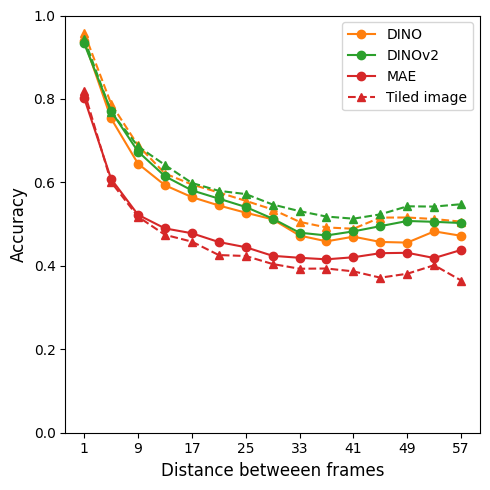

In [14]:
metric_title = {'same_prob': 'Same instance', 'same_cat_prob': 'Same category'}
infer_title = {'full': 'Full image', 'tile': 'Tiled image'}
MODELS = ['dino', 'dinov2', 'mae']
DELTAS = range(1, 61, 2)
plt.figure(figsize=(5,5))
for mi, model in enumerate(MODELS):
    for i, (t, title) in enumerate(infer_title.items()):
        if i == 0:
            label = f'{model_title[model]}'
        else:
            if mi == len(MODELS) - 1:
                label = f'{title}'
            else:
                label = ''
        plt.plot([results[t][model][delta]['same_prob'] for delta in range(1, 61, 4)], '--' if i==1 else '-',
                 label=label, marker='o' if i == 0 else '^' , c=f'C{mi + 1}')

x = [1, 11, 21, 31, 41, 52]
x_label = [1, 11, 21, 31, 41, 52]
x_label = range(1, 61, 8)
print(len(x_label))
plt.xticks(range(0, 15, 2), labels=x_label)
plt.xlabel("Distance between frames", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
#plt.title("", fontsize=15)
#plt.xlabel(DELTAS)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout();
plt.savefig('../tracking/tracking_compare.pdf')

8


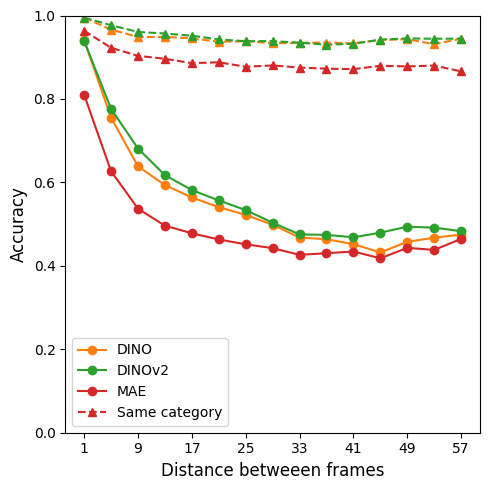

In [11]:
metric_title = {'same_prob': 'Same instance', 'same_cat_prob': 'Same category'}
MODELS = ['dino', 'dinov2', 'mae']
DELTAS = range(1, 61, 2)
plt.figure(figsize=(5,5))
for mi, model in enumerate(MODELS):
    for i, (metric, title) in enumerate(metric_title.items()):
        if i == 0:
            label = f'{model_title[model]}'
        else:
            if mi == len(MODELS) - 1:
                label = f'{title}'
            else:
                label = ''
        plt.plot([results[t][model][delta][metric] for delta in range(1, 61, 4)], '--' if i==1 else '-',
                 label=label, marker='o' if i == 0 else '^' , c=f'C{mi+1}')

x = [1, 11, 21, 31, 41, 52]
x_label = [1, 11, 21, 31, 41, 52]
x_label = range(1, 61, 8)
print(len(x_label))
plt.xticks(range(0, 15, 2), labels=x_label)
plt.xlabel("Distance betweeen frames", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
#plt.title("", fontsize=15)
#plt.xlabel(DELTAS)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout();
plt.savefig('../tracking/tracking_full.pdf')

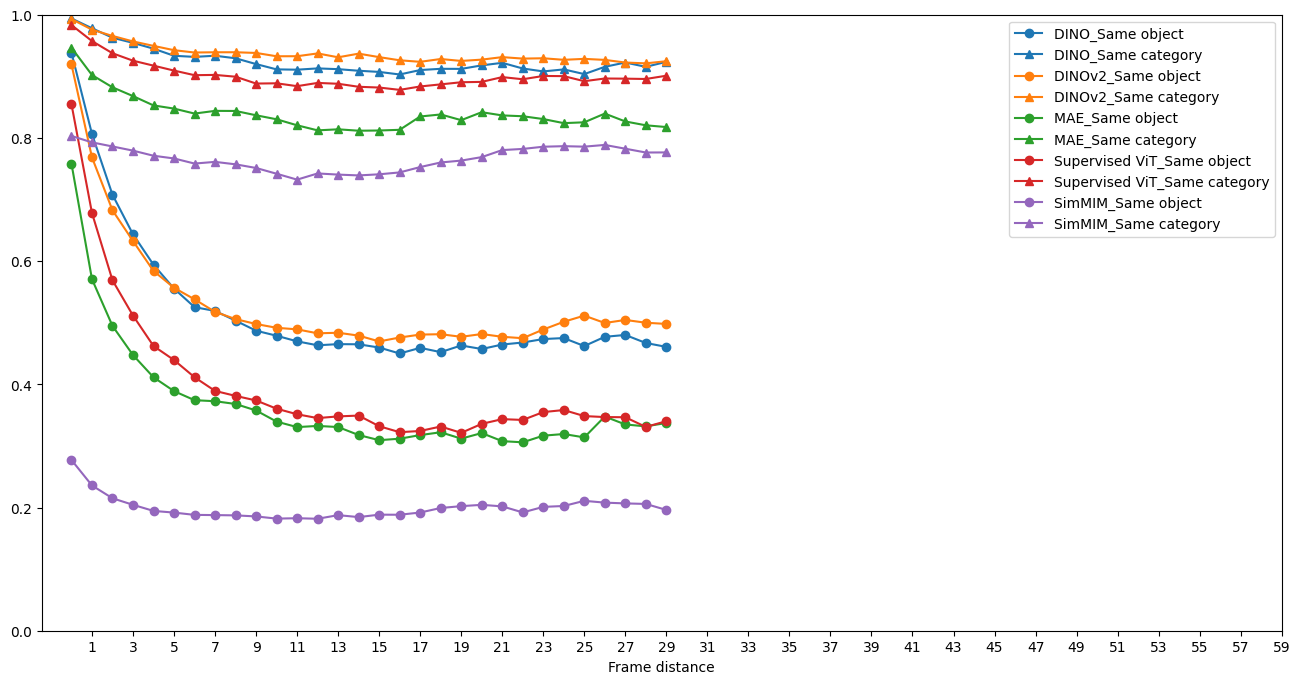

In [141]:
metric_title = {'same_prob': 'Same object', 'same_cat_prob': 'Same category'}

plt.figure(figsize=(16,8))
for mi, model in enumerate(MODELS):
    for i, (metric, title) in enumerate(metric_title.items()):
        plt.plot([results[t][model][delta][metric] for delta in DELTAS], 
                 label=f'{model_title[model]}_{title}', marker='o' if i == 0 else '^' , c=f'C{mi}')

plt.xticks(DELTAS)
plt.xlabel("Frame distance")
#plt.xticklabels(DELTAS)
plt.ylim(0, 1)
plt.legend()
#plt.tight_layout();